In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [70]:
def crop_minAreaRect_with_margin(img, rect, margin=0):
    # Source: https://stackoverflow.com/questions/37177811/

    # Rotate img
    angle = rect[2]
    rows, cols = img.shape[0], img.shape[1]
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rot = cv2.warpAffine(img, matrix, (cols, rows))

    # Rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.intp(cv2.transform(np.array([box]), matrix))[0]
    pts[pts < 0] = 0

    # Add margin to the bounding box coordinates
    pts[:, 0] = np.clip(pts[:, 0], margin, cols - 1 - margin)
    pts[:, 1] = np.clip(pts[:, 1], margin, rows - 1 - margin)

    # Crop and return
    return img_rot[
        pts[1][1] - margin : pts[0][1] + margin, pts[1][0] - margin : pts[2][0] + margin
    ]

dtype: uint8, shape: (122, 120, 3), min: 0, max: 255


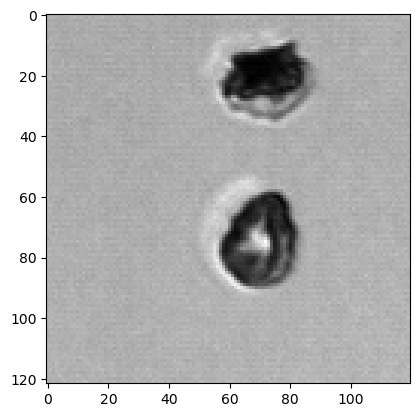

In [71]:
path = "/home/t.afanasyeva/SRF_anemia/temp/images_subset/two_separate.tif"
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"
print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, cmap="grey")

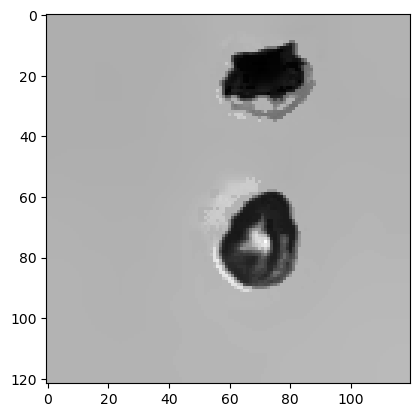

In [72]:
filt = cv2.pyrMeanShiftFiltering(img, sp=10, sr=30, maxLevel=2)
gray = cv2.cvtColor(filt, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="grey")

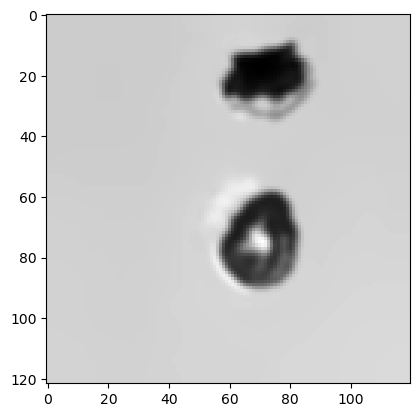

In [73]:
# Smooth image
blur = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blur, cmap="grey")

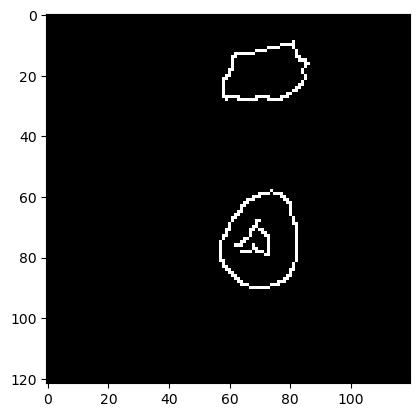

In [74]:
edges = cv2.Canny(blur, threshold1=150, threshold2=200)
plt.imshow(edges, cmap="gray")

In [75]:
# _, threshold = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

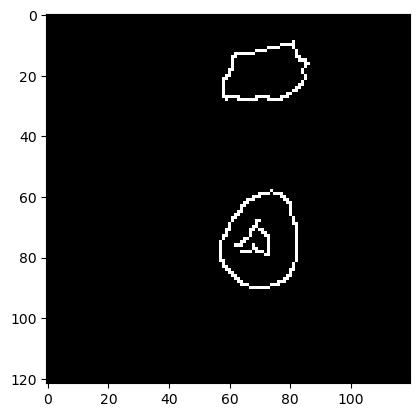

In [76]:
# Remove cells at the border
from skimage.segmentation import clear_border

no_bord = clear_border(edges)
plt.imshow(no_bord, cmap="grey")

In [86]:
# Get larges contour
contours, hierarchy = cv2.findContours(no_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = contours[0]
contours = contours[0] if len(contours) == 2 else contours[1]
largest_cnt = max(contours, key=cv2.contourArea)

# cv2.drawContours(img, [cnt], 0, (0,255,0), 1)
# plt.imshow(img, cmap="gray")

In [89]:
hierarchy

array([[[ 3, -1,  1, -1],
        [-1, -1,  2,  0],
        [-1, -1, -1,  1],
        [-1,  0,  4, -1],
        [-1, -1, -1,  3]]], dtype=int32)

In [78]:
# cv2.fillPoly(stencil, contours, color)
# result = cv2.bitwise_and(img, stencil)

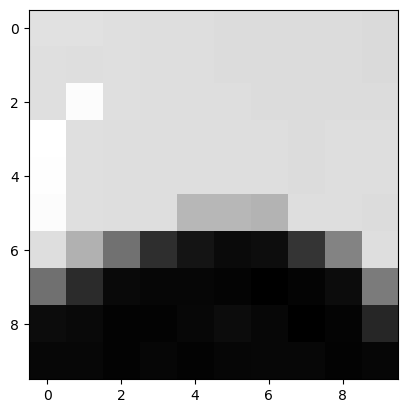

In [79]:
rect = cv2.minAreaRect(largest_cnt)
croped = crop_minAreaRect_with_margin(gray, rect, margin=5)
plt.imshow(croped, cmap="gray")

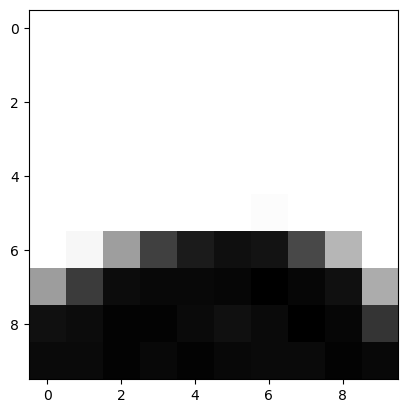

In [80]:
alpha = 1.7
beta = 0
gamma = 0
# for y in range(img_croped.shape[0]):
#   for x in range(img_croped.shape[1]):
# bright = np.clip(alpha*croped + beta, 0, 255)

bright = cv2.addWeighted(croped, alpha, croped, beta, gamma)

plt.imshow(bright, cmap="gray")

In [81]:
def image_resize(image, height=None, inter=cv2.INTER_AREA):
    dimension = None
    (h, w) = image.shape[:2]

    if height is None:
        height = h

    r = height / float(h)  # Resizing ratio
    dimension = (int(w * r), height)

    resized = cv2.resize(image, dimension, interpolation=inter)

    return resized

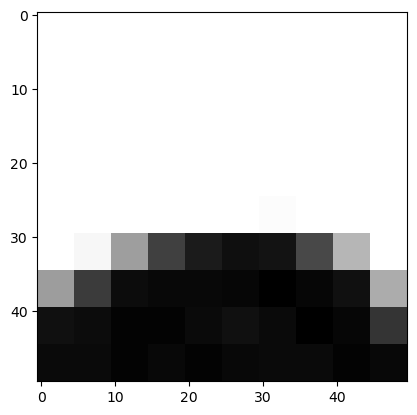

In [82]:
# Resize the image
resized = image_resize(bright, height=50)

plt.imshow(resized, cmap="grey")

In [83]:
def image_pad(src, bordertype=cv2.BORDER_REPLICATE):
    if resized.shape[0] != resized.shape[1]:
        pad_width = abs(resized.shape[1] - resized.shape[0])

    left = pad_width // 2
    right = pad_width - left
    top = 0
    bottom = 0

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, bordertype)

    return padded


padded = image_pad(resized)
plt.imshow(padded, cmap="grey")

UnboundLocalError: cannot access local variable 'pad_width' where it is not associated with a value

In [ ]:
path_out = "/home/t.afanasyeva/SRF_anemia/temp/try.png"

In [ ]:
cv2.imwrite("/home/t.afanasyeva/SRF_anemia/temp/try.png", padded)

True

In [ ]:
import hashlib

with open(path_out, "rb") as f:
    bytes = f.read()  # read entire file as bytes
    readable_hash = hashlib.sha256(bytes).hexdigest()
    print(readable_hash)

db32b8c31c590e374c020821bf87757434327c050c36b2d45c3dfe9867e5da09


In [ ]:
path

'/home/t.afanasyeva/SRF_anemia/temp/images_subset/two_separate.tif'

In [ ]:
my_dict = {}
my_dict.setdefault(readable_hash, [])
my_dict[readable_hash].append(path)

In [ ]:
my_dict[readable_hash].append("discocyte")

In [ ]:
my_dict[readable_hash][1]

'discocyte'

In [ ]:
my_dict

{'db32b8c31c590e374c020821bf87757434327c050c36b2d45c3dfe9867e5da09': ['/home/t.afanasyeva/SRF_anemia/temp/images_subset/two_separate.tif',
  'discocyte']}